In this notebook, we will:

        Read in data and with appropriate transforms (nearly identical to the prior tutorial) using the module dataset.py.
        Set up TensorBoard.
        Write to TensorBoard.
        Inspect a model architecture using TensorBoard.
        Use TensorBoard to create interactive versions of the visualizations we created in last tutorial, with less code



In [16]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import dataset
import Model

In [17]:
mydata = list(dataset.load(img_dir = 'dogs-vs-cats/train/').data()) # Replace this by the the path pointing to the data

import random
random.shuffle(mydata)
n = int(len(mydata)*.3)
test_set = mydata[:n]
train_set = mydata[n:]

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=20, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set,
     batch_size=64, shuffle=True)

In [18]:
# constant for classes
classes = ('cat', 'dog')

In [19]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


We’ll define a similar model architecture from that tutorial, making only minor modifications to account for the fact that the images are now one channel instead of three and 28x28 instead of 32x32:

In [20]:
input_size = 28*28
n_feature = 4
output_size = 2

net = Model.CNN(input_size, n_feature, output_size)

We’ll define the same optimizer and criterion from before:

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 1. TensorBoard setup

Now we’ll set up TensorBoard, importing tensorboard from torch.utils and defining a SummaryWriter, our key object for writing information to TensorBoard.



In [33]:
from torch.utils.tensorboard import SummaryWriter
# The tensorboard data is saved at 'kaggle/cat_dog_experiment_1'
writer = SummaryWriter('kaggle/cat_dog_experiment_1')

### 2. Writing to TensorBoard

Now let’s write an image to our TensorBoard - specifically, a grid - using make_grid.

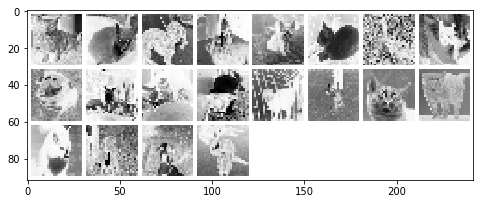

In [34]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
plt.figure(figsize = (8,8))
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('cat_and_dogs_images', img_grid)

[Link to the tutorial](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html?highlight=visualizing%20models%20data%20training%20tensorboard)

### 3. Inspect the model using TensorBoard

One of TensorBoard’s strengths is its ability to visualize complex model structures. Let’s visualize the model we built.

In [35]:
writer.add_graph(net, images)
writer.close()

<img src="graph.png">

### 4. Adding a “Projector” to TensorBoard


In [36]:
# helper function
import random
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    # perm = torch.randperm(len(data))
    return data[:n], labels[:n]

# select random images and their target indices
random.shuffle(train_set)
trainset = list(zip(*train_set))
images, labels = select_n_random(torch.cat(trainset[0],0), list(trainset[1]))

# get the class labels for each image
class_labels = [classes[int(lab)] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

<img src="images/projector.png">

### 5. Tracking model training with TensorBoard


In [37]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[int(preds[idx])],
            probs[idx] * 100.0,
            classes[int(labels[idx])]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig


As we train, we’ll generate an image showing the model’s predictions vs. the actual results on the four images included in that batch.

In [38]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:    # every 10 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 10,
                            epoch * len(train_loader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(train_loader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


<img src="images/scalars.png">

### 6. Assessing trained models with TensorBoard

In [39]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" 0 or 1 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

<img src="images/pr.png">

In [41]:
# This creates the tensorboard and gives the link to open it in the browser
!tensorboard --logdir=kaggle